# Part 3: Modeling

So far so good, we’ve analyzed our data, determined the most decisive features and the different data transformations before training. Now, since our problem is about classification, we’ll focus of the logistic regression classification model, and we’ll train it to distinguish between churned and not churned users.

In [1]:
import pandas as pd

# Data set path
data_path = "C:/Users/Sadek/Documents/GitHub/Project/telecom-customer-churn/data/"

# Import telecom data set into a pandas data frame
df_telecom = pd.read_csv(data_path+"WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Drop non relevant features
df_telecom.drop(columns=["customerID", "gender", "TotalCharges"], inplace=True)

target_name = "Churn"
target = df_telecom[target_name]
data = df_telecom.drop(columns=[target_name])

## 1. Target distribution

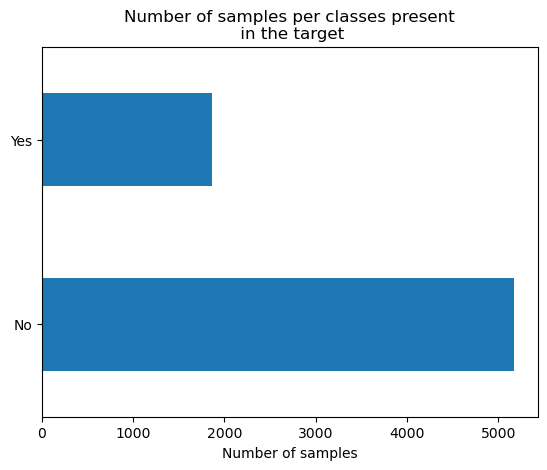

In [42]:
import matplotlib.pyplot as plt

target.value_counts().plot.barh()
plt.xlabel("Number of samples")
_ = plt.title("Number of samples per classes present\n in the target")

The horizontal bar plot indicates an unequal distribution of the target variable. To ensure accurate results, it is advisable to balance the data before training the model. In the subsequent steps, we will balance the data and train multiple versions of the model using both balanced and imbalanced data for comparison.

## 2. Model training
### 2.1. Imbalanced target

In [3]:
from sklearn.compose import make_column_selector as selector

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(data)
categorical_columns = categorical_columns_selector(data)

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [5]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_columns),
    ('cat', categorical_transformer, categorical_columns)
])

A baseline model in machine learning is a model that is used as a reference point for comparison with other more complex models. It is a simple model that is used to establish a performance benchmark for more complex models.

There are many different types of baseline models that can be used, depending on the type of data and the task at hand. Some common examples include:
* A majority class classifier, which always predicts the most common class in the training data
* A random class classifier, which randomly selects a class to predict
* A linear regression model, which makes predictions based on a linear combination of input features

Since our target distribution is unbalanced, we'll proceed with baseline `DummyClassifier` that makes predictions using `most frequent` as strategy.

In [43]:
import sklearn
sklearn.set_config(display="diagram")
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

# First, create a ShuffleSplit object with a specific number of splits and test size
shuffle_split = ShuffleSplit(n_splits=10, test_size=0.3, random_state=42)

# Next, train a dummy classifier using cross validation and the ShuffleSplit object
dummy_classifier = DummyClassifier(strategy='most_frequent')
dummy_classifier = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", dummy_classifier)
])
imbanced_dummy_scores = cross_val_score(dummy_classifier, data, target, cv=shuffle_split)

# Calculate the mean and standard deviation of the dummy classifier's scores
dummy_mean = imbanced_dummy_scores.mean()
dummy_std = imbanced_dummy_scores.std()

# Print the dummy classifier's mean and standard deviation
# print(f"Dummy classifier mean accuracy: {dummy_mean:.4f}")
# print(f"Dummy classifier standard deviation: {dummy_std:.4f}")
print("Dummy classifier Accuracy: %.2f%% - Standard Deviation(%.3f%%)" % (dummy_mean*100, dummy_std))

# Train a logistic regression classifier using cross validation and the ShuffleSplit object
logistic_regression = LogisticRegression(random_state=42)
logistic_regression = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", logistic_regression)
])
imbanced_logistic_scores = cross_val_score(logistic_regression, data, target, cv=shuffle_split)

# Calculate the mean and standard deviation of the logistic regression classifier's scores
logistic_mean = imbanced_logistic_scores.mean()
logistic_std = imbanced_logistic_scores.std()

# Print the logistic regression classifier's mean and standard deviation
# print(f"Logistic regression classifier mean accuracy: {logistic_mean:.4f}")
# print(f"Logistic regression classifier standard deviation: {logistic_std:.4f}")
print("Logistic regression classifier Accuracy: %.2f%% - Standard Deviation(%.3f%%)" % (logistic_mean*100, logistic_std))

Dummy classifier Accuracy: 73.43% - Standard Deviation(0.007%)
Logistic regression classifier Accuracy: 80.39% - Standard Deviation(0.006%)


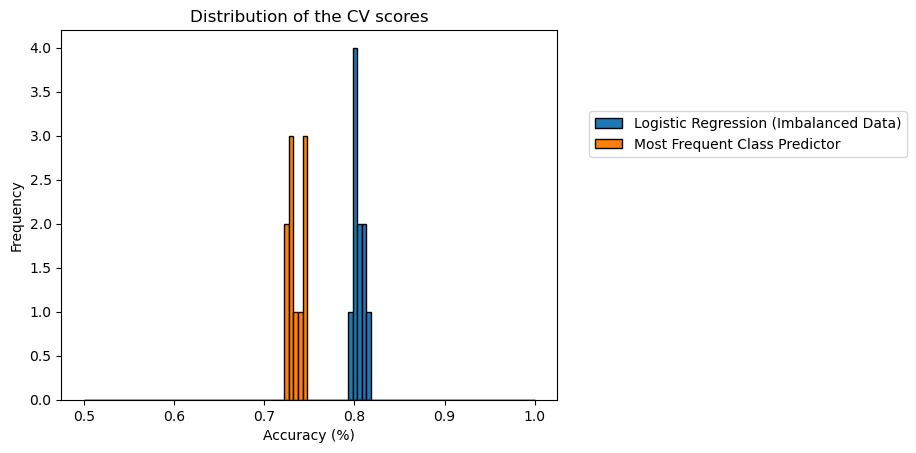

In [44]:
test_score_logistic_regression = pd.Series(
    imbanced_logistic_scores, name="Logistic Regression (Imbalanced Data)"
)

test_score_most_frequent = pd.Series(
    imbanced_dummy_scores, name="Most Frequent Class Predictor"
)

test_scores_imbalanced_data = pd.concat(
    [test_score_logistic_regression, test_score_most_frequent],
    axis='columns',
)

# print(test_scores_imbalanced_data)

import numpy as np

bins = np.linspace(start=0.5, stop=1.0, num=100)
test_scores_imbalanced_data.plot.hist(bins=bins, edgecolor="black")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.xlabel("Accuracy (%)")
_ = plt.title("Distribution of the CV scores")
plt.show()

Based on the information given, the logistic regression classifier has a higher accuracy than the dummy classifier and also has a lower standard deviation, which suggests that it is a more reliable classifier. But both classifiers were trained on an imbalanced data, which will lead us to an optimistic result.

### 2.2. Balanced target

Using `sampling_strategy='minority'` would be a good choice for balancing the data when using the **Synthetic Minority Over-sampling Technique (SMOTE)** algorithm. This strategy will oversample the minority class in the data set so that it has an equal number of samples as the majority class. This can help balance the class distribution and improve the performance of a classifier trained on the balanced data set.

Also, it's generally best to use the `'stratified'` strategy for the DummyClassifier. This will ensure that the class distribution is the same in both the training and test sets, which will make the results more comparable. With the `'most_frequent'` strategy, the DummyClassifier will always predict the majority class, so it would not be a fair comparison with a classifier that uses SMOTE to balance the data.

In [9]:
from imblearn.pipeline import Pipeline as SMOTE_Pipeline
from imblearn.over_sampling import SMOTE

dummy_classifier = SMOTE_Pipeline(steps=[('preprocessor', preprocessor),
                                        ('smote', SMOTE(sampling_strategy='minority')),
                                        ('model', DummyClassifier(strategy='stratified'))])

# Create a ShuffleSplit object with a specific number of splits and test size
# shuffle_split = ShuffleSplit(n_splits=5, test_size=0.3, random_state=42)

# Train a dummy classifier using cross validation and the ShuffleSplit object
# dummy_classifier = DummyClassifier(strategy='most_frequent')
dummy_scores = cross_val_score(dummy_classifier, data, target, cv=shuffle_split)

# Calculate the mean and standard deviation of the dummy classifier's scores
dummy_mean = dummy_scores.mean()
dummy_std = dummy_scores.std()

# Print the dummy classifier's mean and standard deviation
# print(f"Dummy classifier mean accuracy: {dummy_mean:.4f}")
# print(f"Dummy classifier standard deviation: {dummy_std:.4f}")
print("Dummy classifier Accuracy: %.2f%% - Standard Deviation(%.3f%%)" % (dummy_mean*100, dummy_std))


logistic_regression = SMOTE_Pipeline(steps=[('preprocessor', preprocessor),
                                        ('smote', SMOTE(sampling_strategy='minority')),
                                        ('model', LogisticRegression(random_state=42))])

# Train a logistic regression classifier using cross validation and the ShuffleSplit object
# logistic_regression = LogisticRegression(random_state=42)
logistic_scores = cross_val_score(logistic_regression, data, target, cv=shuffle_split)

# Calculate the mean and standard deviation of the logistic regression classifier's scores
logistic_mean = logistic_scores.mean()
logistic_std = logistic_scores.std()

# Print the logistic regression classifier's mean and standard deviation
# print(f"Logistic regression classifier mean accuracy: {logistic_mean:.4f}")
# print(f"Logistic regression classifier standard deviation: {logistic_std:.4f}")
print("Logistic regression classifier Accuracy: %.2f%% - Standard Deviation(%.3f%%)" % (logistic_mean*100, logistic_std))

Dummy classifier Accuracy: 49.97% - Standard Deviation(0.011%)
Logistic regression classifier Accuracy: 75.75% - Standard Deviation(0.010%)


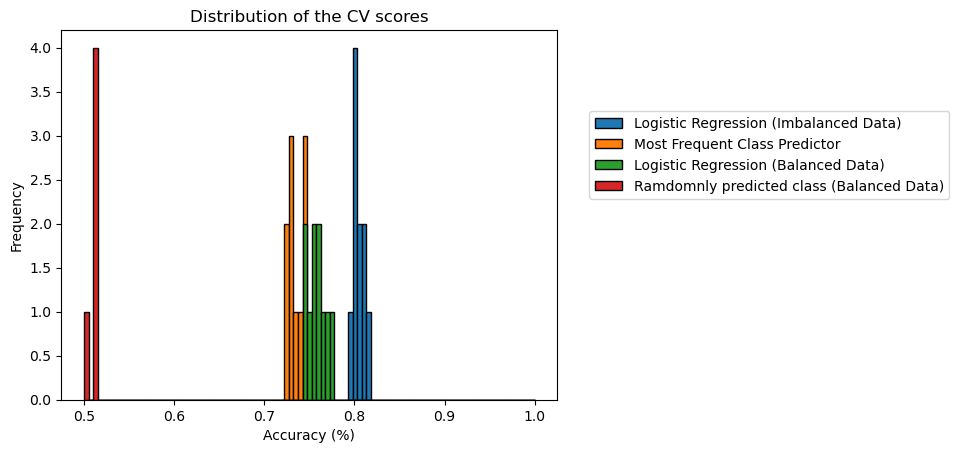

In [11]:
test_score_logistic_regression = pd.Series(
    logistic_scores, name="Logistic Regression (Balanced Data)"
)

test_score_stratified = pd.Series(
    dummy_scores, name="Ramdomnly predicted class (Balanced Data)"
)

all_test_scores = pd.concat(
    [test_scores_imbalanced_data, test_score_logistic_regression, test_score_stratified],
    axis='columns',
)

bins = np.linspace(start=0.5, stop=1.0, num=100)
all_test_scores.plot.hist(bins=bins, edgecolor="black")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.xlabel("Accuracy (%)")
_ = plt.title("Distribution of the CV scores")
plt.show()

With the imbalanced target distribution, the logistic regression classifier had an accuracy of **80.39%** with a standard deviation of **0.006%**, while the dummy classifier had an accuracy of **73.43%** with a standard deviation of **0.007%**. This suggests that the logistic regression classifier was more effective in classifying the imbalanced target distribution compared to the dummy classifier.

With a balanced target distribution obtained using **SMOTE**, the logistic regression classifier had an accuracy of **75.75%** with a standard deviation of **0.010%**, while the dummy classifier had an accuracy of **49.97%** with a standard deviation of **0.011%**. The accuracy of both classifiers decreased compared to the results obtained with the imbalanced target distribution. However, the logistic regression classifier still performed better than the dummy classifier in classifying the balanced target distribution.

It is generally a good idea to try to balance the data before training a classifier, especially if the target variable is imbalanced. An imbalanced dataset can lead to biased results, as the classifier may be more accurate at predicting the majority class and less accurate at predicting the minority class.

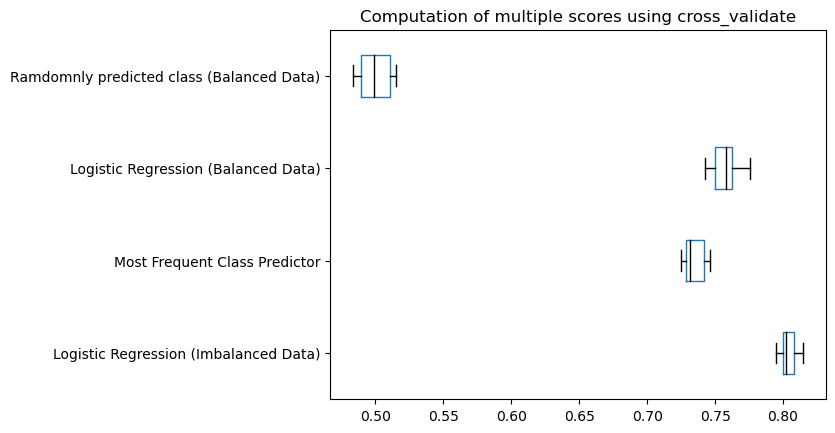

In [12]:
color = {"whiskers": "black", "medians": "black", "caps": "black"}
all_test_scores.plot.box(vert=False, color=color)
_ = plt.title("Computation of multiple scores using cross_validate")

### 2.3. Evaluation of the logistic regression model

In this section, we will balance the data and divide it into training and testing sets, followed by training and evaluating the model. Finally, we will determine the optimal threshold that ensures the most favorable trade-off.

In [45]:
# define the SMOTE object
smote = SMOTE_Pipeline(steps=[('preprocessor', preprocessor),
                              ('smote', SMOTE(sampling_strategy='minority', random_state=42))])

# balance the data
X_resampled, y_resampled = smote.fit_resample(data, target)

In [15]:
y_resampled.value_counts(normalize=True)

No     0.5
Yes    0.5
Name: Churn, dtype: float64

In [46]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print(f"Number of samples in training: {data_train.shape[0]} => "
      f"{data_train.shape[0] / X_resampled.shape[0] * 100:.1f}% of the"
      f" original set")

print(f"Number of samples in testing: {data_test.shape[0]} => "
      f"{data_test.shape[0] / X_resampled.shape[0] * 100:.1f}% of the"
      f" original set")

Number of samples in training: 8278 => 80.0% of the original set
Number of samples in testing: 2070 => 20.0% of the original set


In [50]:
dummy_classifier = DummyClassifier(random_state=42)
dummy_classifier.fit(data_train, target_train)

DummyClassifier(random_state=42)

In [49]:
logistic_regression = LogisticRegression(random_state=42)
logistic_regression.fit(data_train, target_train)

LogisticRegression(random_state=42)

In [51]:
# Make predictions on the test data
target_predicted_LR = logistic_regression.predict(data_test)
target_predicted_DC = dummy_classifier.predict(data_test)

In [23]:
from sklearn.metrics import accuracy_score 

accuracy = accuracy_score(y_true=target_test, y_pred=target_predicted_LR)
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.791


The comparison that we did above and the accuracy that we calculated did not take into account the type of error our classifier was making. Accuracy is an aggregate of the errors made by the classifier. We may be interested in finer granularity - to know independently what the error is for each of the two following cases:

* we predicted that a person will churn but they did not;
* we predicted that a person will not churn but they did.

In a churn detection problem, the goal is to predict which customers are likely to leave, so identifying the churned customers correctly is crucial. The "yes" or "churned" label represents the target variable that the model is trying to predict.

So, churned customer is the **relevant class**, in other word it’s the positive class.

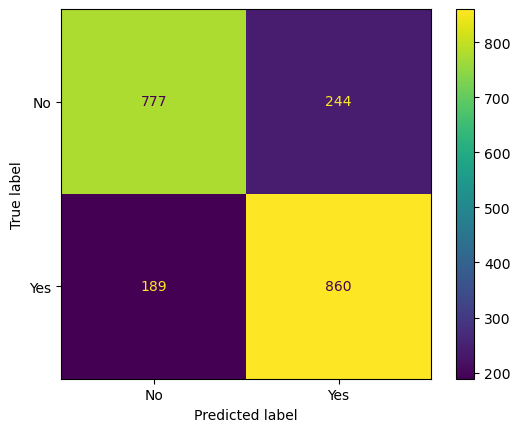

In [53]:
from sklearn.metrics import ConfusionMatrixDisplay

_ = ConfusionMatrixDisplay.from_estimator(logistic_regression, data_test, target_test).percentage = True

In [25]:
from sklearn.metrics import confusion_matrix

# Print the confusion matrix
print(confusion_matrix(target_test, target_predicted_LR)/confusion_matrix(target_test, target_predicted_LR).sum())

[[0.37536232 0.1178744 ]
 [0.09130435 0.41545894]]


The in-diagonal numbers are related to predictions that were correct while off-diagonal numbers are related to incorrect predictions (misclassifications). We now know the four types of correct and erroneous predictions:

* the bottom right corner True positive (TP) — We predict True (“churn”) and the actual label is True (“churn”).
* the top left corner are True negative (TN) — We predict False (“no churn”) and the actual label is also False (“no churn”).

* The top right corner represents False Positives (FP), which are the cases where the model predicts "churn" but the actual label is "no churn".

* The bottom left corner represents False Negatives (FN), which are the cases where the model predicts "no churn" but the actual label is "churn".

We see that the model predicts negative values quite well: 78% of the predictions are true negatives. However, it makes quite a few mistakes of both types: the number of false positives and false negatives is roughly equal (11% and 9%, respectively). 

Precision is the proportion of true positive predictions (i.e. "churn") among all positive predictions made by the model, regardless of whether they are correct or not. It is defined as: **Precision = TP / (TP + FP)**

Recall (also known as sensitivity or true positive rate) is the proportion of true positive predictions made by the model among all actual positive cases (i.e. customers who actually churned). It is defined as: **Recall = TP / (TP + FN)**

In [54]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(target_test, target_predicted_LR, pos_label="Yes")
recall = recall_score(target_test, target_predicted_LR, pos_label="Yes")

print(f"Precision score: {precision:.3f}")
print(f"Recall score: {recall:.3f}")

Precision score: 0.779
Recall score: 0.820


The precision score of **0.779** indicates that out of all the positive predictions made by the logistic regression model (i.e. customers predicted to churn), **77.9%** of them are actually churned customers.\
In the context of the churn detection example, a high precision score means that the model is good at predicting actual churned customers and not predicting non-churned customers as churned. This is important because it reduces the number of false alarms or false positive errors, where the model predicts that a customer will churn but they actually don't.

The recall score of **0.820** indicates that the logistic regression model is able to correctly identify **82.0%** of all the churned customers in the test data.\
In the context of the churn detection example, a high recall score means that the model is good at identifying all the actual churned customers. This is important because it reduces the number of false negatives or missed detections, where the model predicts that a customer will not churn but they actually do.

In this example, the model has a good balance between precision and recall, which is a desirable characteristic for most applications. However, the desired trade-off between precision and recall depends on the specific business problem and the cost of false positive and false negative errors.\
It is common to have a trade-off between precision and recall, as improving one metric often results in a decrease in the other. Therefore, the choice of which metric to optimize depends on the specific requirements and cost of false positive and false negative errors in the business problem. For example, in the churn detection example, it might be more important to have high recall (to minimize missed detections of actual churned customers) or high precision (to minimize false alarms of non-churned customers being predicted as churned).

In [27]:
target_proba_predicted = pd.DataFrame(logistic_regression.predict_proba(data_test),
                                      columns=logistic_regression.classes_)
target_proba_predicted[:5]

,No,Yes
0,0.312081,0.687919
1,0.731167,0.268833
2,0.555699,0.444301
3,0.291276,0.708724
4,0.561915,0.438085


In [28]:
target_predicted = logistic_regression.predict(data_test)
target_predicted[:5]

array(['Yes', 'No', 'No', 'Yes', 'No'], dtype=object)

The default decision threshold (0.5) might not be the best threshold that leads to optimal generalization performance of our classifier. In this case, one can vary the decision threshold.

The precision and recall metric focuses on the positive class, however, one might be interested in the compromise between accurately discriminating the positive class and accurately discriminating the negative classes. The statistics used for this are sensitivity and specificity. Sensitivity is just another name for recall. However, specificity measures the proportion of correctly classified samples in the negative class defined as: TN / (TN + FP). Similar to the precision-recall curve, sensitivity and specificity are generally plotted as a curve called the Receiver Operating Characteristic (ROC) curve. Below is such a curve:

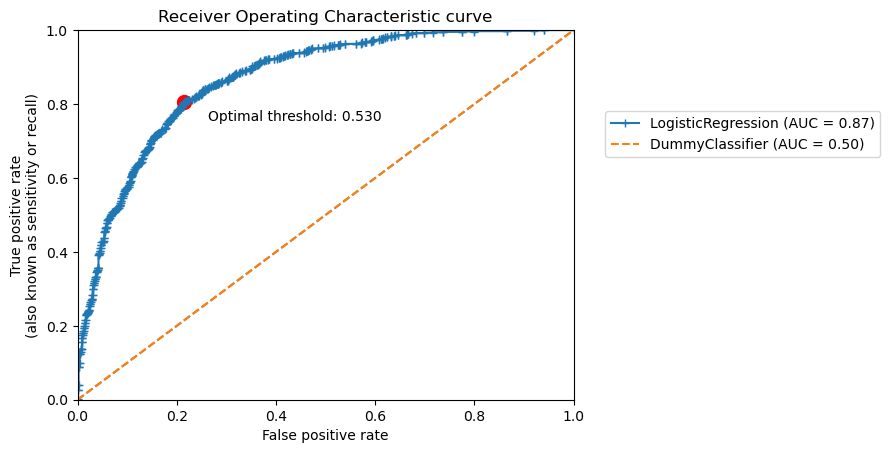

In [55]:
from sklearn.metrics import RocCurveDisplay, roc_auc_score, roc_curve

# Calculate the AUC
auc = roc_auc_score(target_test, logistic_regression.predict_proba(data_test)[:, 1])

# Calculate the FPR, TPR, and thresholds for each prediction probability
fpr, tpr, thresholds = roc_curve(target_test, logistic_regression.predict_proba(data_test)[:, 1], pos_label="Yes")

# Calculate the Youden's J-Index for each threshold
j_index = tpr + (1 - fpr) - 1

# Find the threshold with the highest Youden's J-Index
optimal_threshold = thresholds[j_index.argmax()]

# Plot the ROC curve
disp = RocCurveDisplay.from_estimator(
    logistic_regression, data_test, target_test, pos_label='Yes',
    marker="+")

# Highlight the optimal threshold on the ROC curve
plt.plot([0, 1], [0, 1], linestyle="--", color="tab:gray")
plt.scatter(fpr[j_index.argmax()], tpr[j_index.argmax()], marker="o", color="red", s=100)
plt.annotate(f"Optimal threshold: {optimal_threshold:.3f}", (fpr[j_index.argmax()] + 0.05, tpr[j_index.argmax()] - 0.05))

disp = RocCurveDisplay.from_estimator(
    dummy_classifier, data_test, target_test, pos_label='Yes',
    color="tab:orange", linestyle="--", ax=disp.ax_)

plt.xlabel("False positive rate")
plt.ylabel("True positive rate\n(also known as sensitivity or recall)")

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = disp.ax_.set_title("Receiver Operating Characteristic curve")

This curve was built using the same principle as the precision-recall curve: we vary the probability threshold for determining “hard” prediction and compute the metrics. As with the precision-recall curve, we can compute the area under the ROC (ROC-AUC) to characterize the generalization performance of our classifier. However, it is important to observe that the lower bound of the ROC-AUC is 0.5. Indeed, we show the generalization performance of a dummy classifier (the orange dashed line) to show that even the worst generalization performance obtained will be above this line.

We can calculate the optimal FPR and TPR by finding the coordinates of the point on the ROC curve with the highest Youden's J-Index. Youden's J-Index is calculated as TPR + TNR - 1, where TNR is the True Negative Rate (1 - FPR). The Youden's J-Index provides a single number that summarizes the overall performance of the classifier at a specific threshold.

In [32]:
# Define the new threshold
threshold = 0.530

df = target_proba_predicted.copy()

# Create a new column "class_predicted" using the threshold to convert the predicted probabilities into binary classifications
df['class_predicted'] = ["Yes" if p >= threshold else "No" for p in df['Yes']]

# Calculate the accuracy with the new threshold
accuracy = accuracy_score(target_test, df["class_predicted"])
print(f"Accuracy with new threshold: {accuracy:.3f}")

Accuracy with new threshold: 0.796


By setting the threshold to 0.530, we achieved a higher accuracy than with the default threshold of 0.5, which was 0.791 < 0.796

In [33]:
precision = precision_score(target_test, df["class_predicted"], pos_label="Yes")
recall = recall_score(target_test, df["class_predicted"], pos_label="Yes")

print(f"Precision with new threshold: {precision:.3f}")
print(f"Recall with new threshold: {recall:.3f}")

Precision with new threshold: 0.795
Recall with new threshold: 0.805


* Old Precision score: 0.779
* Old Recall score: 0.820

With a threshold of 0.53, the precision score increases to 0.795 and the recall score decreases to 0.805. This means that with a higher threshold, the model becomes more precise in its positive predictions but misses a few more positive examples in the test set.